# Plot historical progress reading past assessments

In [8]:
import glob
import pandas as pd
from ml_quality.assessments import QualityAssessment

def get_quality_maturity_score(summary_path: str):
    df = pd.read_csv(summary_path)
    assessment = QualityAssessment(name="", date="2024-01-01")
    # name and date are irrelevant since we get those from the assessment path

    assessment.set_gaps_from_csv(summary_path, reason_col_name=None)
    return assessment.compute_quality_score(df["gap_value"]), assessment.maturity


def get_improvement_data(path: str):

    evaluations = glob.glob(path)
    print(f"N. evaluations: {len(evaluations)}")
    evaluation_dates = [ev.split("/")[-2] for ev in evaluations]
    print(f"N. evaluation dates: {len(evaluation_dates)}")
    models = [ev.split("/")[-3] for ev in evaluations]
    print(f"N. unique models: {len(set(models))}")

    df_imp = pd.DataFrame({"model": models, "date": evaluation_dates, "summary": evaluations})
    df_n_evals = pd.DataFrame(df_imp.groupby("model")["date"].count()).reset_index().rename(columns={"date": "count"})
    df_imp = pd.merge(df_imp, df_n_evals, how="left", on="model")
    df_imp = df_imp[df_imp["count"] > 1]
    quality_maturity_scores = [get_quality_maturity_score(path) for path in df_imp.summary.tolist()]
    print(f"N. quality scores: {len(quality_maturity_scores)}")
    df_imp["quality_score"] = [q[0] for q in quality_maturity_scores]
    df_imp["maturity"] = [q[1] for q in quality_maturity_scores]
    df_imp["improvement"] = df_imp["quality_score"] - df_imp.sort_values(by=["model", "date"]).groupby("model")["quality_score"].shift(1)
    df_imp["iteration"] = df_imp.groupby("model")["quality_score"].rank("first")
    return df_imp

### Retrieve past evaluation data

In [9]:
df_history = get_improvement_data(path="../assessments/example_reports/**/**/**/summary.csv")

N. evaluations: 41
N. evaluation dates: 41
N. unique models: 11
N. quality scores: 41


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_improvement_plot(df_data: pd.DataFrame):
    maturity_levels = sorted(df_data["maturity"].unique())
    markers = ["$\mathbf{" + str(i) + "}$" for i in maturity_levels]

    sns.set_style("ticks")
    ax = sns.lineplot(df_data, x="iteration", y="quality_score", hue="model")
    sns.scatterplot(data=df_data, x="iteration", y="quality_score", style="maturity", markers=markers, s=150, hue="model", legend=False)

    plt.xticks(np.arange(1,max(maturity_levels) +1,1))
    plt.ylabel("Quality Score")
    plt.xlabel("Iteration")
    plt.grid()
    plt.legend(title="Model", alignment="left").get_title().set_fontweight("bold")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig("plots/paper_improvement.png", bbox_inches="tight")

### Plot quality score per iteration with maturity as marker

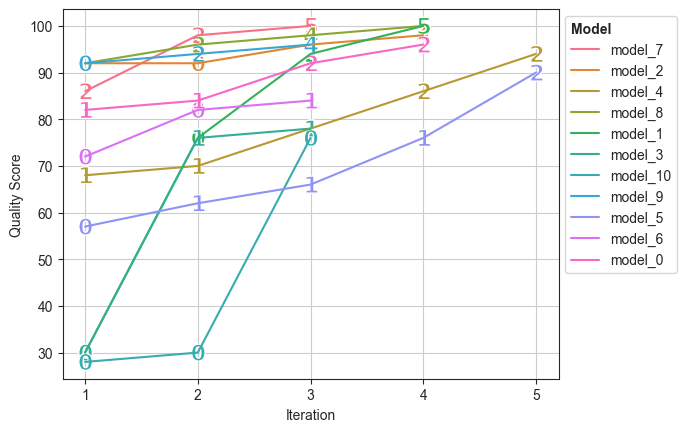

In [11]:
make_improvement_plot(df_history)

In [7]:
import glob
import pandas as pd
for p in glob.glob("../assessments/example_reports/**/**/**/summary.csv"):
    df_s = pd.read_csv(p)
    if "url" in df_s.columns:
        df_s.drop(columns=["url"], inplace=True)
        df_s.to_csv(p, index=False)
